# 1. Pobieranie danych i konfiguracja środowiska

Zainicjowano środowisko pracy poprzez import niezbędnych bibliotek systemowych oraz analitycznych (`os`, `glob`, `pandas`, `kagglehub`). Następnie pobrano zbiór danych "Superstore Marketing Campaign Dataset" bezpośrednio z repozytorium Kaggle. Zbiór ten zawiera dane dotyczące kampanii marketingowej supermarketu planującego wprowadzenie złotego członkostwa dającego 20% zniżki. Celem analizy jest budowa modelu predykcyjnego klasyfikującego klientów skłonnych do zakupu oferty. Po pobraniu plików zweryfikowano poprawność ścieżki dostępu oraz wczytano główny plik CSV do struktury ramki danych `pandas` w celu dalszego przetwarzania.

In [1]:
import os # funkcjonalności związane z systemem
import glob # pathname pattern expansion
import pandas as pd # analiza danych
import kagglehub # ściąganie danych z Kaggle

# @title Download Dataset
dataset_slug = "ahsan81/superstore-marketing-campaign-dataset" # lokalizacja zbioru w Kaggle
path = kagglehub.dataset_download(dataset_slug) # ściąganie danych do path

csv_files = glob.glob(os.path.join(path, "*.csv"))
if len(csv_files) == 0:
    raise FileNotFoundError(f"No CSV files found in: {path}") # weryfikacja zapisu

customer_data = pd.read_csv(csv_files[0]) # przypisanie danych do zmiennej

Using Colab cache for faster access to the 'superstore-marketing-campaign-dataset' dataset.


# 2. Wstępne przetwarzanie danych (Preprocessing)

Przeprowadzono wstępne czyszczenie surowych danych. W pierwszej kolejności usunięto rekordy zawierające braki danych (NA) w kolumnie docelowej `Response`, a samą zmienną przekonwertowano na typ kategoryczny. Obliczono nową zmienną `Age` (wiek klienta) na podstawie roku urodzenia (`Year_Birth`) i bieżącej daty, eliminując jednocześnie zbędną kolumnę identyfikacyjną `Id`. W końcowym etapie tej fazy odfiltrowano ze zbioru wiersze nieposiadające informacji o dochodach (`Income`), aby zapewnić kompletność danych wejściowych do modelowania.

In [2]:
from datetime import date # lib do dat

# @title Preprocessing
data_raw = customer_data.copy()

data_clean = (data_raw
    .dropna(subset=['Response']) # usunięcie NA
    .assign(
        Response=lambda x: x['Response'].astype('category'), # zmiana na zmienną kategoryczną
        Age=lambda x: date.today().year - x['Year_Birth'] # dodanie wieku
    )
    .drop(columns=['Id'])
    .query("Marital_Status not in ['Alone', 'YOLO', 'Absurd']")
)

data_clean = data_clean.dropna(subset=['Income']) # usunięcie wierszy bez dochodów

# 3. Inżynieria cech (Feature Engineering)

Dokonano wzbogacenia zbioru danych poprzez wygenerowanie nowych zmiennych objaśniających. Utworzono zmienną `Total_Spending`, stanowiącą agregację wydatków klienta na różne kategorie produktów (wina, owoce, mięso, ryby, słodycze, produkty złote). Wyznaczono wskaźnik recencji (`Recency`), określający liczbę lat, jakie upłynęły od rejestracji klienta w bazie. Dodatkowo przeprowadzono standaryzację typów danych, konwertując wybrane kolumny numeryczne (m.in. liczby zakupów w różnych kanałach, liczbę dzieci) na typ całkowity (`int`), co zweryfikowano poprzez wyświetlenie listy kolumn i wymiarów nowej struktury danych.

In [3]:
# @title Feature Engineering

# Dodanie kolumn Total_Spending i Recency
data_fe = (data_clean
    .assign(
        Total_Spending = lambda x: (
            x['MntWines'] + x['MntFruits'] + x['MntMeatProducts'] +
            x['MntFishProducts'] + x['MntSweetProducts'] + x['MntGoldProds']
        ),
        Recency = lambda x: (
            date.today().year -
            pd.to_datetime(x['Dt_Customer'], format='%m/%d/%Y').dt.year
        )
    )
)

int_cols = [
    'Kidhome', 'Teenhome', 'NumWebPurchases', 'NumCatalogPurchases',
    'NumStorePurchases', 'NumDealsPurchases', 'NumWebVisitsMonth'
]

# Konwersja kolumn do int
data_fe[int_cols] = data_fe[int_cols].astype(int)

# Weryfikacja
print(f"New column count: {data_fe.shape[1]}")
print(f"Columns: {data_fe.columns.tolist()}")

New column count: 23
Columns: ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Response', 'Complain', 'Age', 'Total_Spending']


# 4. Eksploracyjna analiza danych (EDA)

Przeprowadzono szczegółową analizę rozkładu zmiennych w celu identyfikacji wzorców oraz wartości odstających. Zmienne podzielono na grupy: ciągłe, dyskretne, nominalne oraz czasowe. Dla zmiennych ciągłych wygenerowano histogramy z estymacją gęstości jądrowej (KDE) oraz wykresy pudełkowe, co pozwoliło na ocenę skośności rozkładów. Zmienne dyskretne zobrazowano za pomocą uporządkowanych wykresów słupkowych. Przeanalizowano dynamikę rejestracji klientów w czasie, stosując resampling miesięczny. Strukturę zmiennych kategorycznych zweryfikowano poprzez wykresy liczebności. Ostatecznie obliczono macierz korelacji dla zmiennych numerycznych, wizualizując ją za pomocą mapy ciepła w celu wykrycia współliniowości cech.

Wygenerowano serię wykresów (histogramy, boxploty, wykresy słupkowe, liniowy wykres szeregu czasowego oraz heatmapę korelacji).

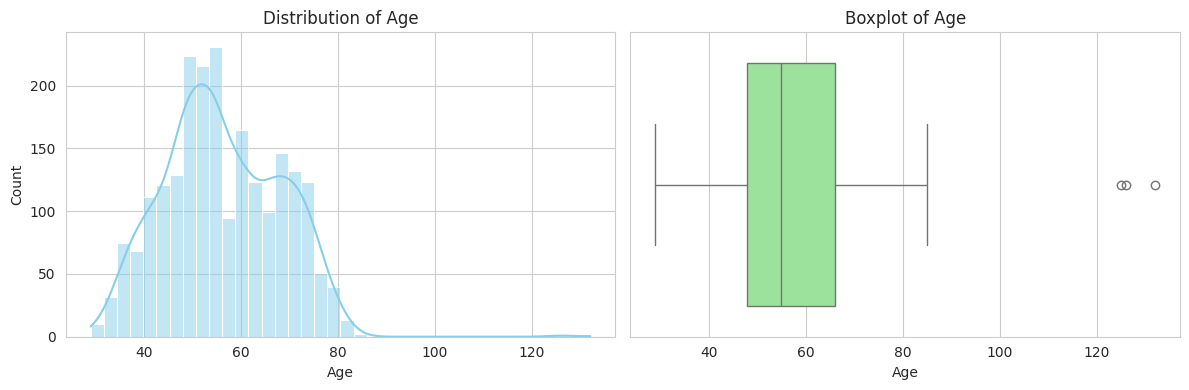

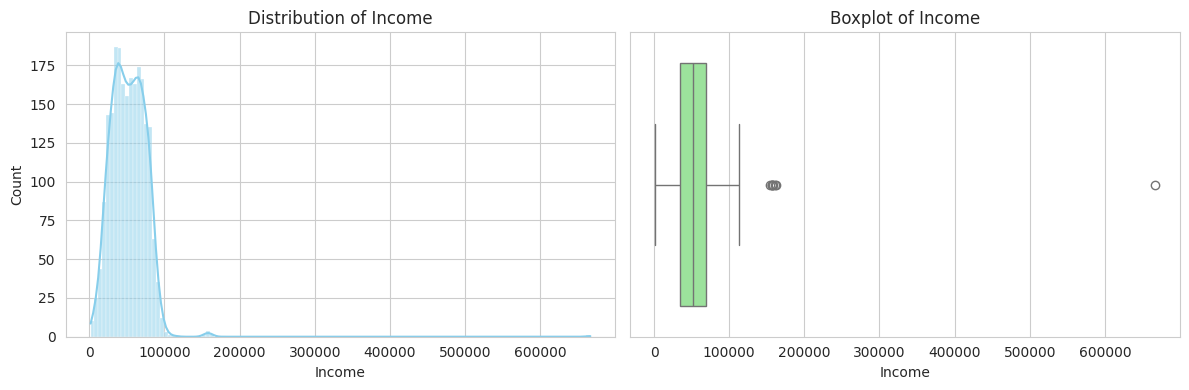

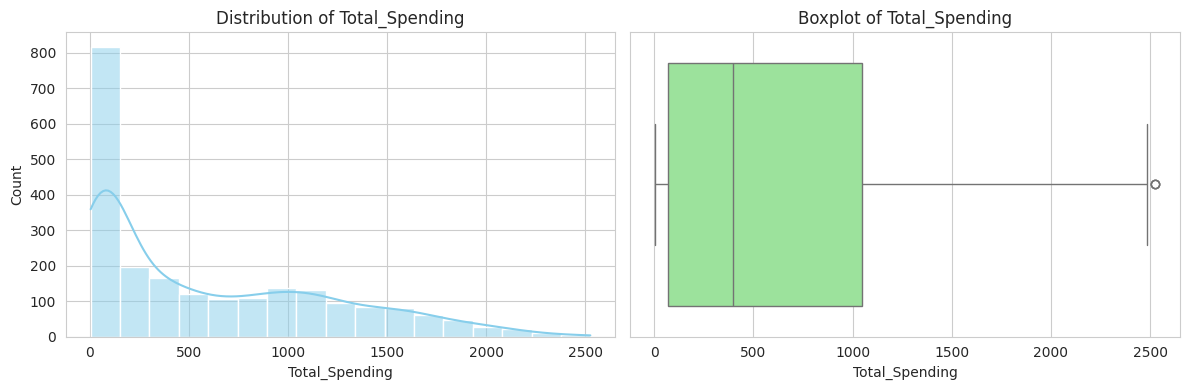

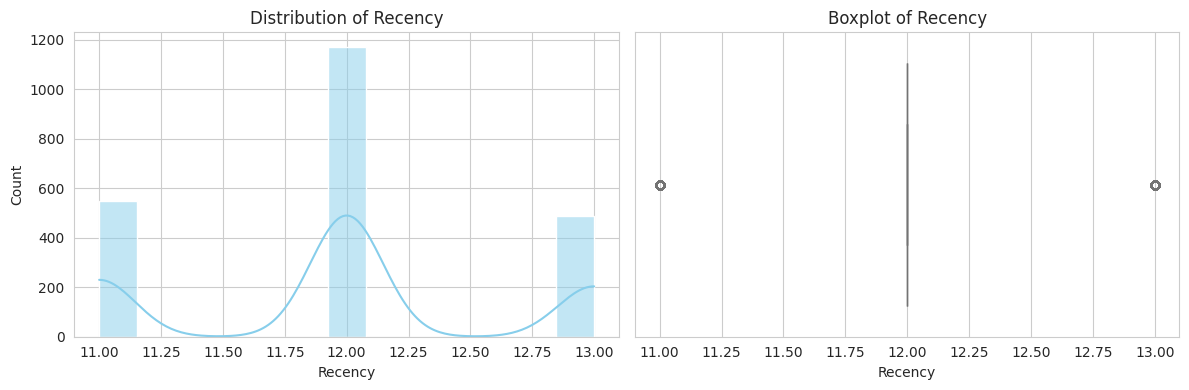

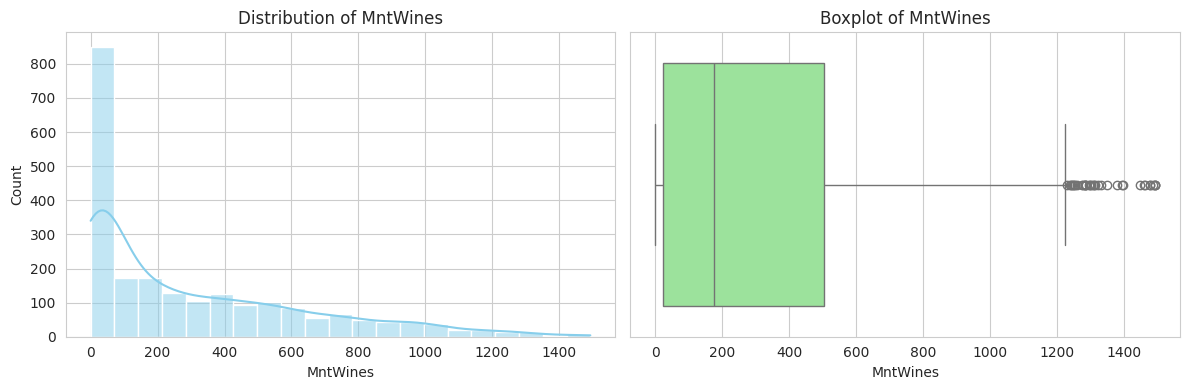

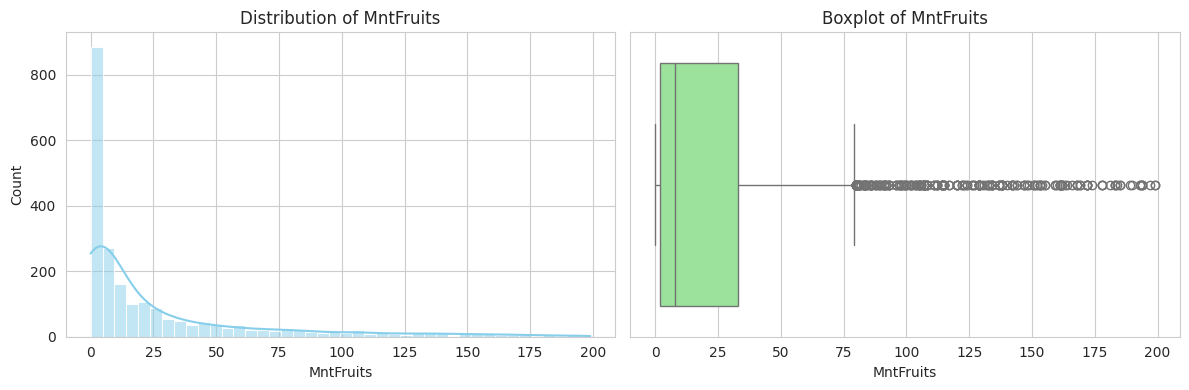

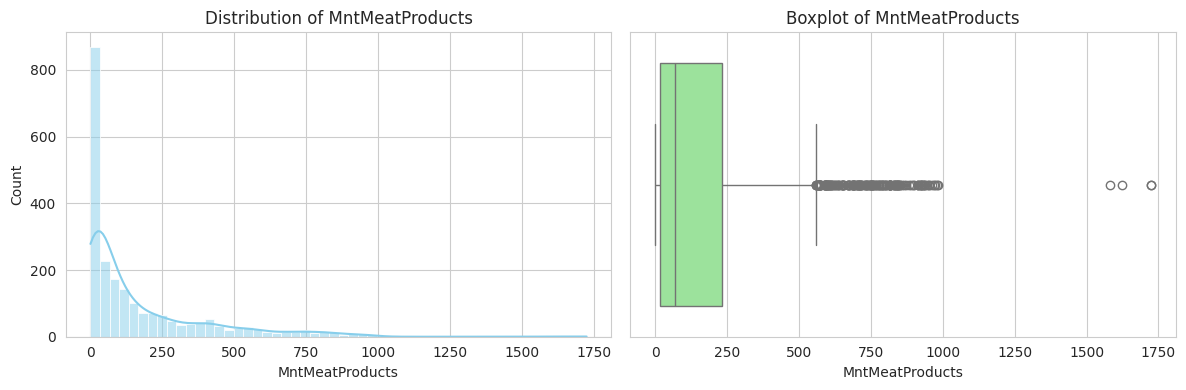

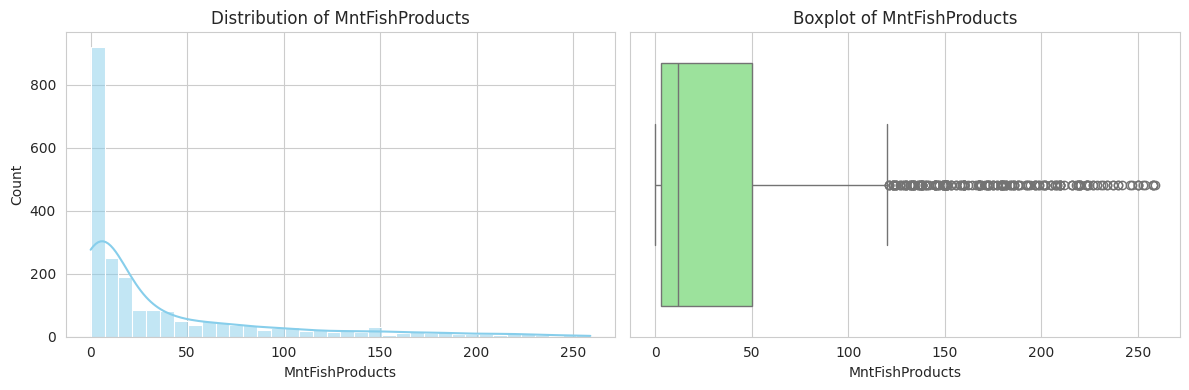

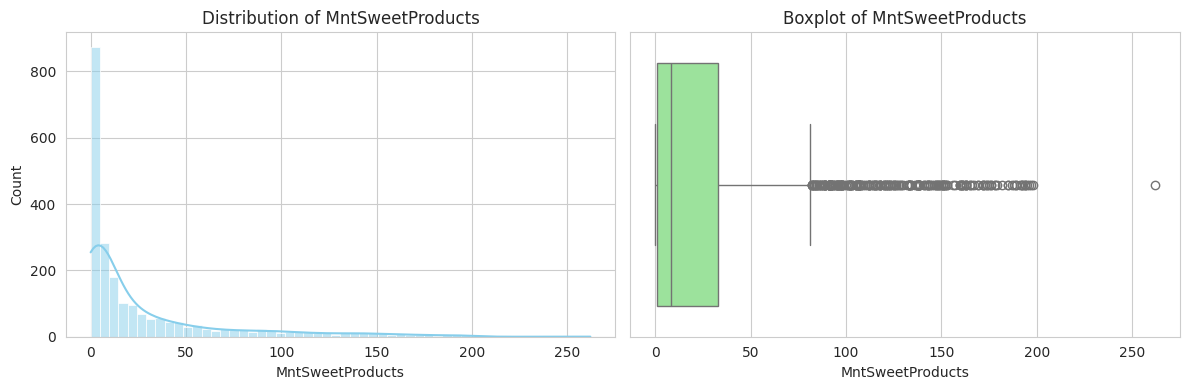

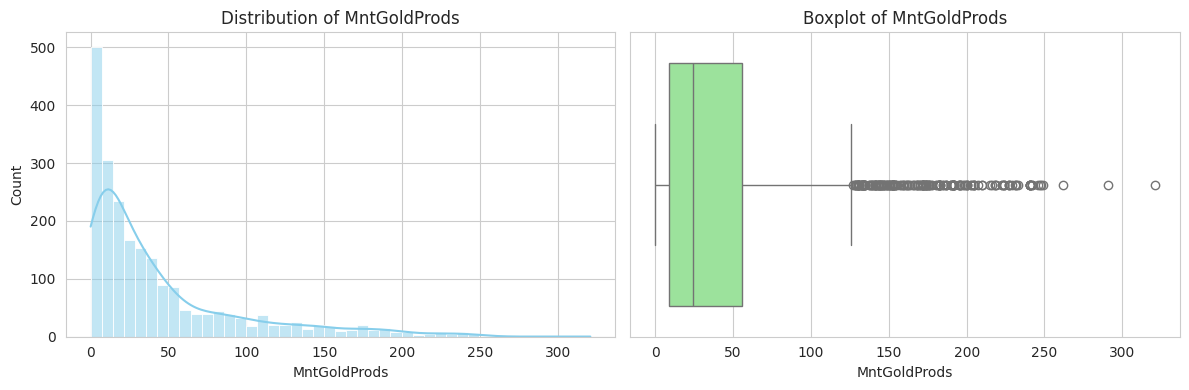

/tmp/ipython-input-3076856293.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_data.index, y=count_data.values, palette="viridis")


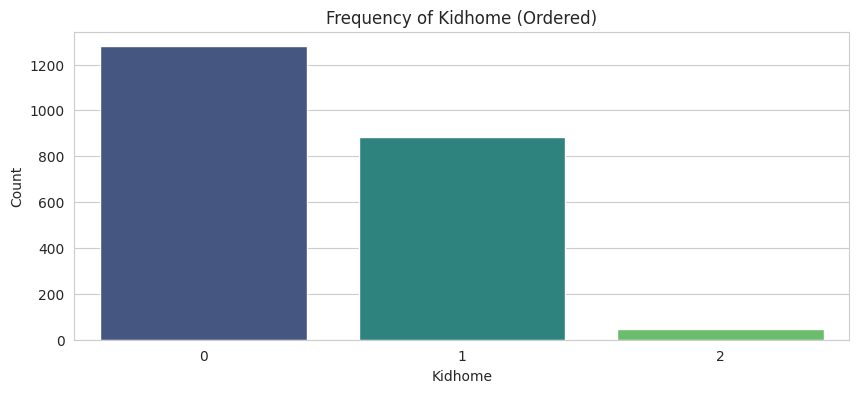

/tmp/ipython-input-3076856293.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_data.index, y=count_data.values, palette="viridis")


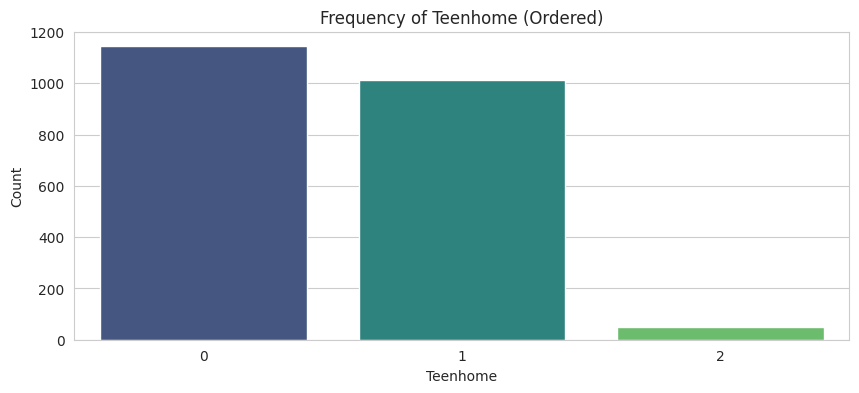

/tmp/ipython-input-3076856293.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_data.index, y=count_data.values, palette="viridis")


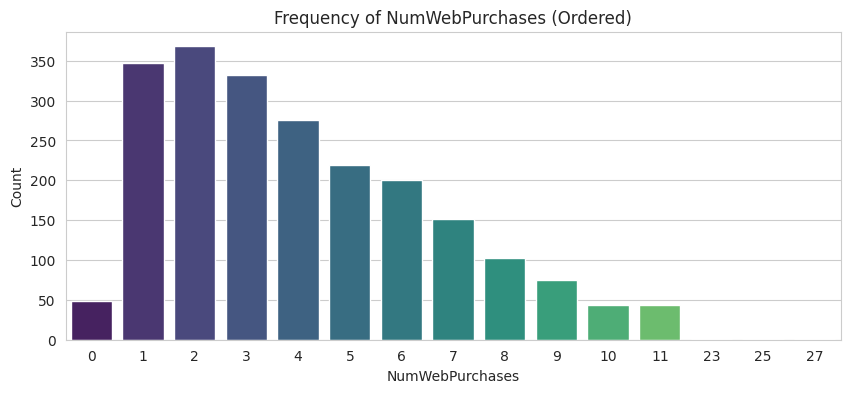

/tmp/ipython-input-3076856293.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_data.index, y=count_data.values, palette="viridis")


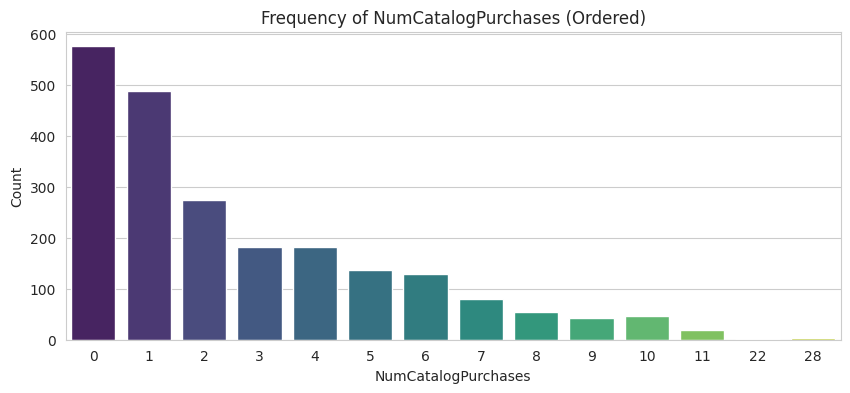

/tmp/ipython-input-3076856293.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_data.index, y=count_data.values, palette="viridis")


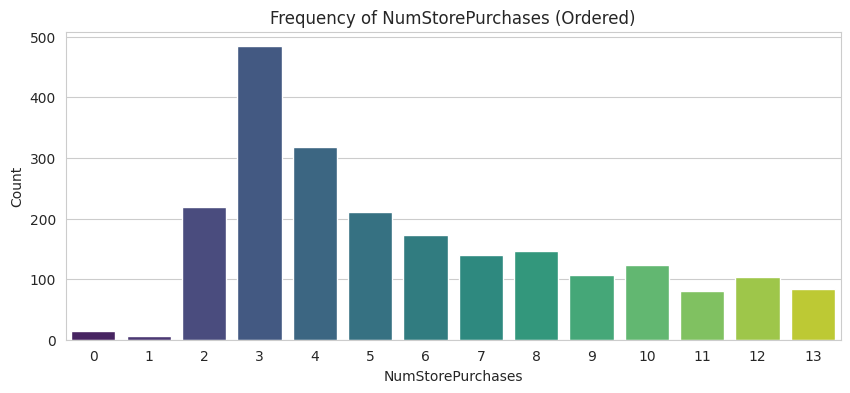

/tmp/ipython-input-3076856293.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_data.index, y=count_data.values, palette="viridis")


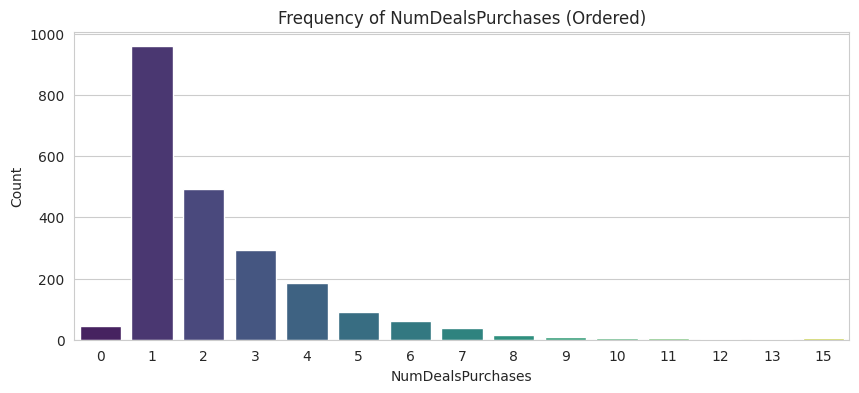

/tmp/ipython-input-3076856293.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_data.index, y=count_data.values, palette="viridis")


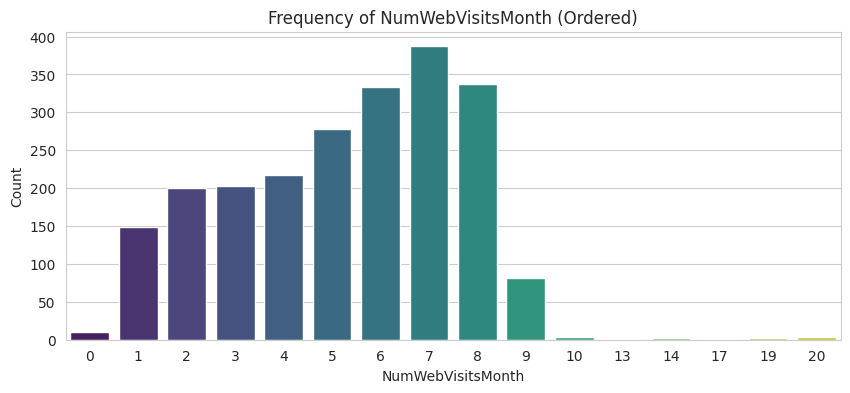

/tmp/ipython-input-3076856293.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_fe['Dt_Customer'].value_counts().resample('M').sum().plot()


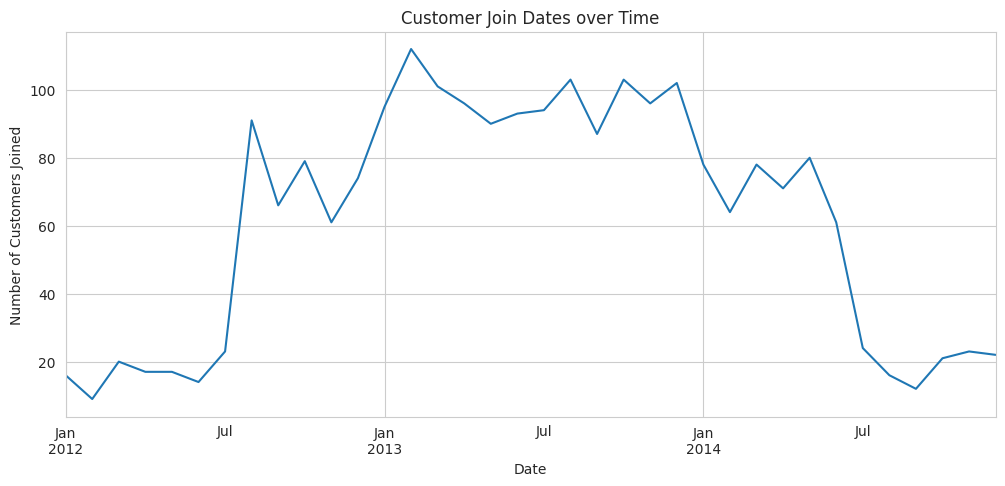

/tmp/ipython-input-3076856293.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_fe, x=col, order=data_fe[col].value_counts().index, palette="pastel")


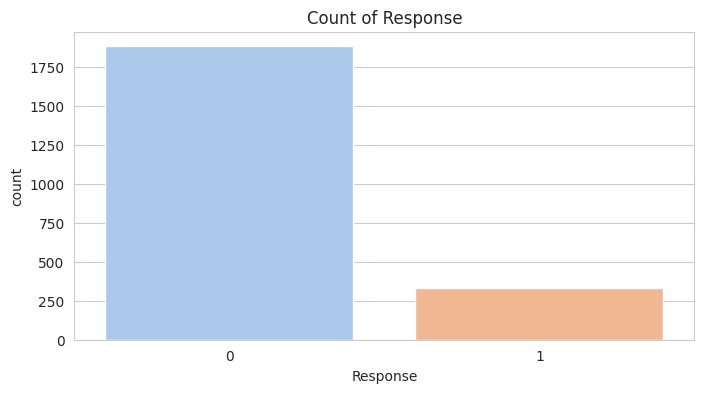

/tmp/ipython-input-3076856293.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_fe, x=col, order=data_fe[col].value_counts().index, palette="pastel")


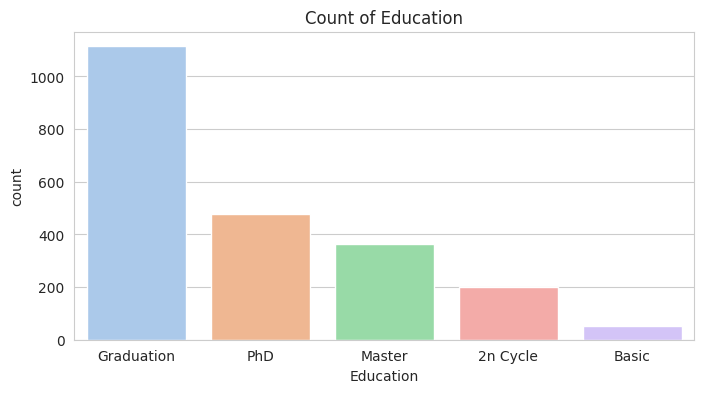

/tmp/ipython-input-3076856293.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_fe, x=col, order=data_fe[col].value_counts().index, palette="pastel")


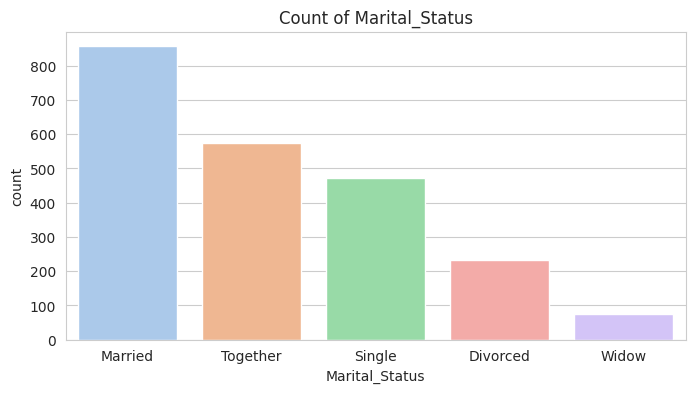

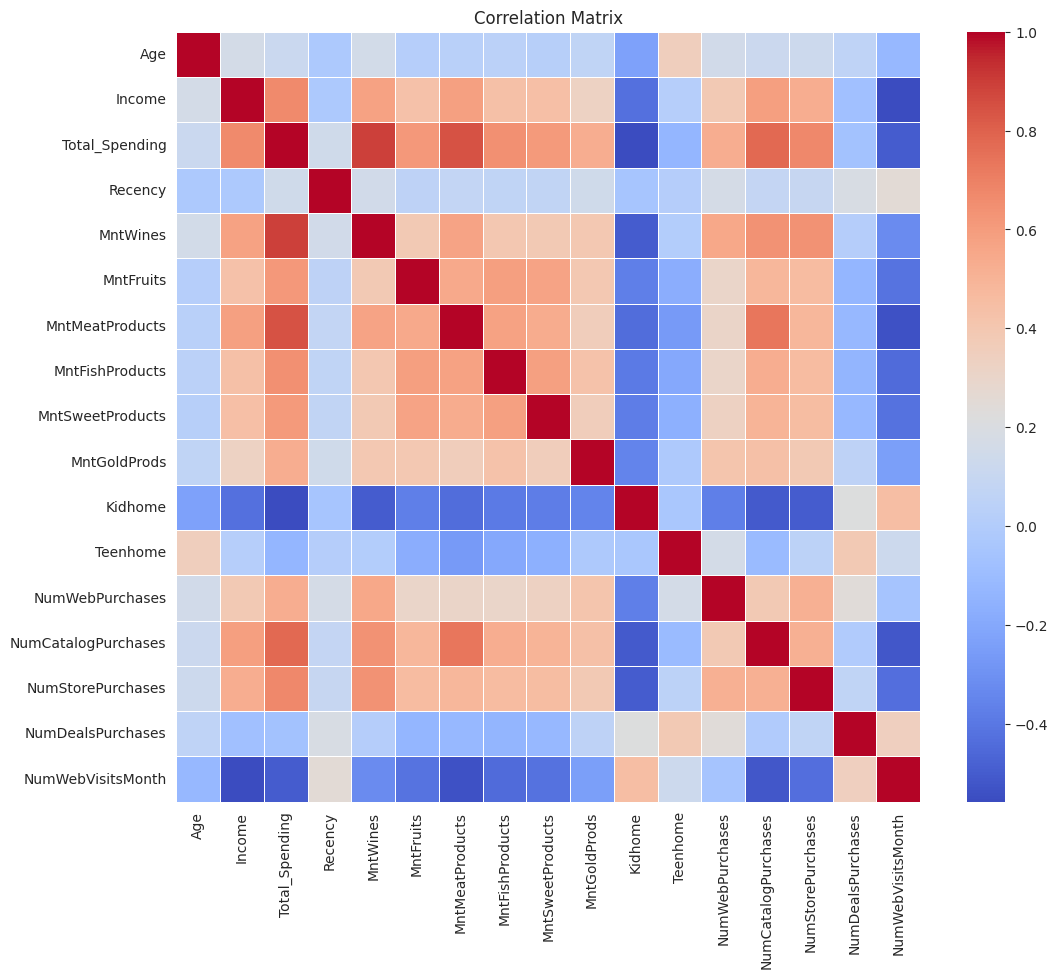

In [4]:
# @title Exploratory Data Analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # statystyka
import numpy as np

# styl dla wszystkich wykresów
sns.set_style("whitegrid")

# Definicja grup wykresów ------------------------------------------------------

continuous_vars = ['Age', 'Income', 'Total_Spending', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'] # zmienne ciągłe
discrete_vars = ['Kidhome', 'Teenhome', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'NumWebVisitsMonth'] # zmienne dyskretne
nominal_vars = ['Response', 'Education', 'Marital_Status'] # zmienne kategoryczne
date_vars = ['Dt_Customer'] # daty

# Logika generowania wykresów --------------------------------------------------

# Zmienne ciągłe (Histogram + Boxplot)
for col in continuous_vars:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram
    sns.histplot(data=data_fe, x=col, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribution of {col}')

    # Boxplot
    sns.boxplot(x=data_fe[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

# Zmienne dyskretne (Ordered Bar Charts)
for col in discrete_vars:
    plt.figure(figsize=(10, 4))

    # Wykres słupkowy według indeksu
    count_data = data_fe[col].value_counts().sort_index()
    sns.barplot(x=count_data.index, y=count_data.values, palette="viridis")
    plt.title(f'Frequency of {col} (Ordered)')
    plt.xlabel(col)
    plt.ylabel('Count')

    plt.show()

# Daty (Time Series Distribution)
data_fe['Dt_Customer'] = pd.to_datetime(data_fe['Dt_Customer'], errors='coerce')
plt.figure(figsize=(12, 5))

# Resampling miesiąca
data_fe['Dt_Customer'].value_counts().resample('M').sum().plot()
plt.title('Customer Join Dates over Time')
plt.ylabel('Number of Customers Joined')
plt.xlabel('Date')
plt.show()

# Zmienne Kategoryczne (by Frequency)
for col in nominal_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data_fe, x=col, order=data_fe[col].value_counts().index, palette="pastel")
    plt.title(f'Count of {col}')
    plt.show()

# Macierz korelacji
plt.figure(figsize=(12, 10))

# Połączenie zmiennych ciągłych i dyskretnych dla wykresu
corr_cols = continuous_vars + discrete_vars
corr = data_fe[corr_cols].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# 5. Podział zbioru danych (Train-Test Split)

Dokonano podziału przetworzonego zbioru danych na podzbiór treningowy oraz testowy w proporcji 70:30. Zastosowano mechanizm stratyfikacji względem zmiennej celu (`Response`), co zapewniło zachowanie reprezentatywnego rozkładu klas w obu podzbiorach i zapobiegło problemom wynikającym z niezbalansowania danych. Zdefiniowano również obiekt 5-krotnej walidacji krzyżowej (`StratifiedKFold`) z losowym mieszaniem danych, przeznaczony do późniejszej oceny stabilności modeli.

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold # dzielenie na podzbiory ze stratyrikacją

# @title Train-Test Split
train_data, test_data = train_test_split(
    data_fe,
    train_size=0.7,
    stratify=data_fe['Response'],
    random_state=123
)

# 5-fold CV, stratyfikacja według Response
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# 6. Definicja potoku przetwarzania (Pipeline Setup)

Zaprojektowano i zaimplementowano potok przetwarzania danych (`Pipeline`) wykorzystujący `ColumnTransformer`. Dla zmiennych numerycznych zastosowano imputację braków danych medianą oraz standaryzację (`StandardScaler`) w celu ujednolicenia skali cech. Zmienne kategoryczne poddano kodowaniu gorącojedynkowemu (`OneHotEncoder`) z pominięciem pierwszej kategorii dla uniknięcia współliniowości, a następnie znormalizowano. Całość procesu uzupełniono o globalny selektor cech oparty na progu wariancji, eliminujący zmienne o zerowej zmienności.

In [6]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

# @title Recipe Definition & Pipeline Setup

# Definicja selektorów dla kolumn według typów danych
numeric_selector = make_column_selector(dtype_include=np.number)
categorical_selector = make_column_selector(dtype_include=object)

# Definicja transformerów (skalowanie i mediana)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
  )

# Kategoryczne: OneHot (Dummy) -> Normalize
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')),
    ('scaler', StandardScaler())]
  )

# Połączenie w preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_selector),
        ('cat', categorical_transformer, categorical_selector)
    ],
    verbose_feature_names_out=False
)

# Filtr erowej wariancji (globalnie)
recipe_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('zv', VarianceThreshold(threshold=0))] # remove features with 0 variance
 )

# Przygotowanie x i y
X_train = train_data.drop(columns=['Response'])
y_train = train_data['Response']

# 7. Konfiguracja metryk i przechowywania wyników

Opracowano funkcję pomocniczą służącą do systematycznej ewaluacji i archiwizacji wyników eksperymentów. Funkcja ta oblicza szereg metryk klasyfikacyjnych: dokładność, precyzję, czułość, miarę F1, pole pod krzywą ROC (AUC), błędy MSE i MAE oraz macierz pomyłek. Zaimplementowano mechanizm ekstrakcji architektury sieci neuronowej (liczba warstw ukrytych, liczba neuronów, liczba parametrów trenowalnych). Wyniki te są dopisywane do globalnej ramki danych, umożliwiając późniejsze porównanie efektywności różnych konfiguracji.

In [7]:
# @title Shared Setup + Results Storage

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  roc_auc_score,
  mean_squared_error,
  mean_absolute_error,
  confusion_matrix
) # metryki dopasowania modelu (goodness of fit)

# Instalacja scikeras (inaczej Colab wyrzuca błąd po restarcie sesji)
try:
    import scikeras
except ImportError:
    !pip install scikeras
    import scikeras

from scikeras.wrappers import KerasClassifier # wrapper dla kerasa, umożliwia stosowania z scikeras
import tensorflow as tf # lib zawierający TensorFlow, tj. operacje tensorowe
from tensorflow.keras import layers, regularizers, Input, Model # elementy składowe sieci neuronowej

# Tabela z wynikami
nn_results = pd.DataFrame()

# Funkcja do dopisywania wierszy do tabeli z wynikami
def add_results_row(
  model_name,
  best_model,
  y_test,
  y_pred,
  y_prob
):
  # obliczanie metryk
  accuracy_val = accuracy_score(y_test, y_pred)
  precision_val = precision_score(y_test, y_pred, zero_division=0)
  recall_val = recall_score(y_test, y_pred, zero_division=0)
  f1_val = f1_score(y_test, y_pred, zero_division=0)
  roc_auc_val = roc_auc_score(y_test, y_prob)
  mse_val = mean_squared_error(y_test, y_prob)
  mae_val = mean_absolute_error(y_test, y_prob)
  conf_mat = confusion_matrix(y_test, y_pred)

  # informacja o modelu
  keras_model = best_model.model_
  layers_info = []
  for layer in keras_model.layers:
    if isinstance(layer, layers.Dense):
      layers_info.append({
        'name': layer.name,
        'units': layer.output_shape[-1],
        'trainable_params': layer.count_params()
      })

  hidden_layers_count = sum(1 for l in layers_info if l['name'].startswith('hidden'))
  neurons_per_layer = [l['units'] for l in layers_info if l['name'].startswith('hidden')]
  total_params = keras_model.count_params()

  # tworzenie wiersza
  row = {
    'model_name': model_name,
    'hidden_layers': hidden_layers_count,
    'neurons_per_layer': neurons_per_layer,
    'total_trainable_params': total_params,
    'accuracy': accuracy_val,
    'precision': precision_val,
    'recall': recall_val,
    'f1_score': f1_val,
    'roc_auc': roc_auc_val,
    'mse': mse_val,
    'mae': mae_val,
    'confusion_matrix': conf_mat
  }

  global nn_results
  nn_results = pd.concat([nn_results, pd.DataFrame([row])], ignore_index=True)

# 8. Eksperyment A: Strojenie modelu bibliotecznego

Przeprowadzono optymalizację hiperparametrów standardowego klasyfikatora wielowarstwowego perceptronu (`MLPClassifier`) ze Scikit-Learn. Zdefiniowano przestrzeń poszukiwań obejmującą topologię sieci, współczynnik regularyzacji L2, początkową szybkość uczenia, parametr pędu oraz liczbę iteracji. Wykorzystano metodę przeszukiwania siatki (`GridSearchCV`) ze stratyfikowaną walidacją krzyżową, optymalizując model pod kątem metryki ROC AUC. Wyłoniono najlepszy estymator do dalszych porównań.

**Wyniki widoczne w outpucie:**
System wypisał optymalne parametry znalezione przez algorytm oraz najlepszy uzyskany wynik walidacji.

In [8]:
# @title Eksperyment A: Strojenie gotowego modelu bibliotecznego (Scikit-Learn)

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# 1. Konstrukcja potoku (Pipeline)
library_pipeline = Pipeline([
    ('recipe', recipe_pipeline), # wczytanie preprocessingu zdefiniowanego wcześniej
    ('mlp', MLPClassifier(solver='sgd', early_stopping=True, random_state=123)) # klasyfikator (Multi-layer Perceptron)
])

# 2. Definicja hiperparametrów do przeszukania
lib_params = {
    'mlp__hidden_layer_sizes': [(10,), (20,), (10, 5), (20, 10, 5)], # topologia sieci (liczba neuronów w warstwach ukrytych)
    'mlp__alpha': [0.1, 0.01, 0.001, 0.0001], # parametr regularyzacji L2 (karze duże wagi)
    'mlp__learning_rate_init': [0.1, 0.01, 0.001, 0.0001], # początkowy współczynnik uczenia
    'mlp__momentum': [0.5, 0.8, 0.9, 0.95],
    'mlp__max_iter': [200, 500, 1000, 1500]
}

# 3. Uruchomienie przeszukiwania siatki (Grid Search)

# Definicja walidacji krzyżowej (zachowanie proporcji klas)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# Konfiguracja obiektu szukającego
lib_search = GridSearchCV(
    library_pipeline,
    lib_params,
    cv=cv,
    scoring='roc_auc', # metryka optymalizowana
    n_jobs=-1 # użycie wszystkich rdzeni CPU
)

# Trenowanie modelu na danych treningowych
lib_search.fit(X_train, y_train)
best_lib_model = lib_search.best_estimator_

# Wyświetlenie najlepszych parametrów i wyników
print(f"✅ Best Library Params: {lib_search.best_params_}")
print(f"✅ Best Library AUC: {lib_search.best_score_:.3f}")

✅ Best Library Params: {'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (10, 5), 'mlp__learning_rate_init': 0.1, 'mlp__max_iter': 200, 'mlp__momentum': 0.9}
✅ Best Library AUC: 0.788


# 9. Eksperyment B: Implementacja i strojenie własnej sieci neuronowej

Zaimplementowano autorską klasę `CustomNumpyNN` realizującą algorytm sieci neuronowej w czystym NumPy. Zdefiniowano metody inicjalizacji wag, funkcję aktywacji sigmoidalnej, propagację w przód, obliczanie funkcji kosztu (binarna entropia krzyżowa) oraz wsteczną propagację błędu z uwzględnieniem mechanizmu Momentum. Estymator włączono w potok przetwarzania i poddano strojeniu hiperparametrów (rozmiar warstw, learning rate, momentum, epoki) w ramach przeszukiwania siatki, analogicznie do modelu bibliotecznego.

**Wyniki widoczne w outpucie:**
System wypisał optymalne parametry dla modelu autorskiego oraz jego wynik walidacji.

In [9]:
# @title Eksperyment B: Poprawiona własna sieć NumPy

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# Definicja własnego estymatora kompatybilnego z Scikit-Learn
class CustomNumpyNN(ClassifierMixin, BaseEstimator):

    _estimator_type = "classifier" # classifierMixin musi być pierwszy (wymóg dziedziczenia dla metod typu score)

    def __init__(self, hidden_layer_sizes=(10,), learning_rate=0.01, momentum=0.9, epochs=1000, random_seed=None):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.epochs = epochs
        self.random_seed = random_seed

    def _sigmoid(self, z):
        # Funkcja aktywacji (z zabezpieczeniem przed overflow/underflow)
        z = np.clip(z, -500, 500) # overflow protection
        return 1 / (1 + np.exp(-z)) # sigmoid curve -> zwraca liczbę z przedziału od 0 do 1 (0: silny negatywny wynik, 1: silny pozytywny wynik, 0.5: niepewność)

    def _sigmoid_derivative(self, a):
        # Pochodna sigmoidy dla propagacji wstecznej
        return a * (1 - a) # douczanie bazujące na stopniu niepewności - jeśli neuron jest niepewny wyniku (0.5 lub blisko) następuje najsilniejsze douczanie

    def _initialize_weights(self, n_features):
        # Inicjalizacja generatora losowego
        rng = np.random.RandomState(self.random_seed) # random_seed generuje przypadkowe liczby z np.random.RandomState (lista losowych liczb)

        self.weights_ = []
        self.biases_ = []

        # Prędkość dla Momentum (Velocity)
        self.v_weights_ = []
        self.v_biases_ = []

        # 1. Warstwa wejściowa -> Pierwsza warstwa ukryta
        layer_input_size = n_features

        # 2. Iteracja przez zdefiniowane warstwy ukryte
        for layer_size in self.hidden_layer_sizes:
            # Inicjalizacja wag (małe wartości losowe)
            w = rng.randn(layer_input_size, layer_size) * 0.1 # bardzo małe wartości * 0.1 zapewniają, ze sieć znajduje się na starcie w optymalnym zakresie do szynkiego uczenia
            b = np.zeros((1, layer_size)) # zera - brak biasów

            self.weights_.append(w)
            self.biases_.append(b)

            # Inicjalizacja wektorów pędu (zera)
            self.v_weights_.append(np.zeros_like(w))
            self.v_biases_.append(np.zeros_like(b))

            layer_input_size = layer_size

        # 3. Ostatnia warstwa ukryta -> Warstwa wyjściowa (1 neuron, klasyfikacja binarna)
        w_out = rng.randn(layer_input_size, 1) * 0.1
        b_out = np.zeros((1, 1))

        self.weights_.append(w_out)
        self.biases_.append(b_out)

        self.v_weights_.append(np.zeros_like(w_out))
        self.v_biases_.append(np.zeros_like(b_out))

    def _forward(self, X): # aktualizacja aktywacji połączeń między neuronami, sekwencyjnie, warstwa po warstwie
        # Propagacja w przód (Forward Propagation)
        self.As_ = [X] # dane z x_train (dla 100 klientow i 20 kolumn: macierz o wymiarach 100x20) / warstwa 1: 10 neuronów / warstwa 2: 5 neuronów
        current_input = X # aktualny input to po prostu X

        for i in range(len(self.weights_)): # dla każdej warstwy wag
            W = self.weights_[i] # zapisz aktualne wagi / macierz o wymiarach (20, 10) - 20 kolumn, 10 neuronów
            b = self.biases_[i] #zapisz aktualny bias

            # Obliczenie sumy ważonej i aktywacji
            Z = np.dot(current_input, W) + b # iloczyn skalarny (dot product) aktualnych aktywacji i wag + bias -> mnożymy macierze (100, 20) • (20, 10) + (100, 10) = (100, 10)
                                             # policzyliśmy sumę ważoną każdego klienta z każdym neuronem w tej warstwie
            A = self._sigmoid(Z) # funkcja sigmoidalna dla wszystkich wag -> tłumaczymy uzyskane wartości na przedział [0,1] -> (100, 10)

            self.As_.append(A) # aktualizacja current_input -> dodajemy aktualną warstwę wag to tabeli, ma teraz dwie macierze: [(100, 20), (100, 10)]
            current_input = A # current_input jest aktualizowany i zawiera tylko aktywacje właśnie aktualizowanej warstwy: (100, 10), kolejna warstwa zaczyna pętlę od tego miejsca

        return current_input # końcowa wartość

    def fit(self, X, y): # X (features) oraz y (labels)
        # Walidacja wejścia (Scikit-Learn utils)
        X, y = check_X_y(X, y) # sprawdzamy czy dane są liczbowe
        self.classes_ = unique_labels(y) # zapisuje możliwe wartości y (0 albo 1)
        self.n_features_in_ = X.shape[1] # ilośc kolumn w danych
        y = y.astype(float).reshape(-1, 1) # format

        self._initialize_weights(self.n_features_in_) # buduja macierz bardzo małych wartości wstępnych dla macierzy wag
        self.loss_history_ = []

        m = X.shape[0] # wiersze

        # Pętla uczenia (Epochs)
        for epoch in range(self.epochs):
            # Forward
            A_final = self._forward(X) # przepuszczanie danych X przez forward() warstwa po warstwie od input (surowe dame) do output (predykcja) - jedna kolumna z predykcjami

            # Loss Function (Binary Cross Entropy)
            loss = -np.mean(y * np.log(A_final + 1e-15) + (1 - y) * np.log(1 - A_final + 1e-15)) # obliczenie średniego błędu ("1e-15" unika błędu numerycznego log(0)) - [0.9 - 1.0, 0.2 - 0.0, ...] -> szacunek 0.5 to wartość ok. −ln(0.5) ≈ 0.693
            self.loss_history_.append(loss)

            # Backward (Wsteczna propagacja błędu)
            dZ = A_final - y # obliczenie błędu prognozy
            num_layers = len(self.weights_)

            for i in range(num_layers - 1, -1, -1): # idziemy od ostatniej warstwy (output) do pierwszej (input)
                A_prev = self.As_[i] # aktywacje poprzedniej warstwy (te, które spowodowały błąd w aktualnej warstwie)

                # Gradienty dla wag i biasów
                dW = (1 / m) * np.dot(A_prev.T, dZ) # gradient, tj. błąd warstwy -> mnożymy: sumaryczny błąd modelu x aktywacja warstwy (duże akywacje blisko 1 będą miały duże gradient)
                db = (1 / m) * np.sum(dZ, axis=0, keepdims=True) # suma gradientu

                if i > 0: # jeśli za nami jest ukryta warstwa...
                    # Propagacja błędu do poprzedniej warstwy (Chain Rule)
                    dZ_prev = np.dot(dZ, self.weights_[i].T) * self._sigmoid_derivative(self.As_[i]) # waga * błąd * aktywacja -> Error Signal = (Who sent it?) × (How bad is it?) × (Was the line open?)
                else:
                    dZ_prev = None

                # Aktualizacja wag z użyciem Momentum
                self.v_weights_[i] = (self.momentum * self.v_weights_[i]) - (self.learning_rate * dW)
                self.v_biases_[i]  = (self.momentum * self.v_biases_[i]) - (self.learning_rate * db)
                # momentum - spowalnia proces uczenia się (np. 0.9)
                # v_weights_ - prędkość i kierunek zmiany
                # learning_rate - siła uczenia na podstawie gradientu
                # dW - wielkośc i kierunek błędu
                # znaczenie: w zależności od kierunku i wielkości błędu, będziemy spowalniać lub przyspieszać proces uczenia się

                self.weights_[i] += self.v_weights_[i] # update wag
                self.biases_[i]  += self.v_biases_[i]

                dZ = dZ_prev

        return self

    def predict_proba(self, X):
        # Zwraca prawdopodobieństwa dla obu klas (wymagane przez ROC AUC)
        check_is_fitted(self)
        X = check_array(X)
        A_final = self._forward(X)
        # Format wyjścia: [P(klasa_0), P(klasa_1)]
        return np.hstack([1 - A_final, A_final])

    def predict(self, X):
        # Predykcja etykiet (threshold 0.5)
        probas = self.predict_proba(X)[:, 1]
        return (probas > 0.5).astype(int)

# --- PONOWNE STROJENIE (RE-RUN TUNING) ---

# 1. Aktualizacja pipeline
custom_pipeline = Pipeline([
    ('recipe', recipe_pipeline), # preprocessing zdefiniowany wcześniej
    ('custom', CustomNumpyNN(random_seed=123))
])

# 2. Definicja hiperparametrów
custom_params = {
    'custom__hidden_layer_sizes': [(10,), (20,), (10, 5), (20, 10, 5)], # różne topologie
    'custom__learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'custom__momentum': [0.5, 0.8, 0.9, 0.95],
    'custom__epochs': [200, 500, 1000, 1500]
}

# 3. Uruchomienie przeszukiwania siatki (Grid Search)
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

custom_search = GridSearchCV(
    custom_pipeline,
    custom_params,
    cv=cv_stratified,
    scoring='roc_auc',
    n_jobs=1 # custom numpy implementation is single-threaded mostly
)

custom_search.fit(X_train, y_train)
best_custom_model = custom_search.best_estimator_

print(f"✅ Best Custom Params: {custom_search.best_params_}")
print(f"✅ Best Custom AUC: {custom_search.best_score_:.3f}")

✅ Best Custom Params: {'custom__epochs': 500, 'custom__hidden_layer_sizes': (10, 5), 'custom__learning_rate': 0.1, 'custom__momentum': 0.95}
✅ Best Custom AUC: 0.819


# 10. Analiza porównawcza (Benchmarking)

Przeprowadzono kompleksowe porównanie modeli na wydzielonym zbiorze testowym. Oprócz najlepszych modeli z obu eksperymentów, wyodrębniono i wytrenowano modele biblioteczne o średnich (mediana) i najgorszych wynikach z etapu walidacji krzyżowej, aby stworzyć punkt odniesienia. Wygenerowano zbiorczy wykres krzywych ROC, zestawienie słupkowe kluczowych metryk (Accuracy, AUC, F1) oraz siatkę macierzy pomyłek dla wszystkich wariantów, co pozwoliło na ostateczną weryfikację skuteczności własnej implementacji.

BEST LIBRARY MODEL (SCIKIT-LEARN)
Best CV ROC-AUC: 0.7882

Optimal Hyperparameters:
 ➔ mlp__alpha: 0.1
 ➔ mlp__hidden_layer_sizes: (10, 5)
 ➔ mlp__learning_rate_init: 0.1
 ➔ mlp__max_iter: 200
 ➔ mlp__momentum: 0.9

BEST CUSTOM MODEL (NUMPY)
Best CV ROC-AUC: 0.8187

Optimal Hyperparameters:
 ➔ custom__epochs: 500
 ➔ custom__hidden_layer_sizes: (10, 5)
 ➔ custom__learning_rate: 0.1
 ➔ custom__momentum: 0.95

Generowanie pełnego raportu graficznego...


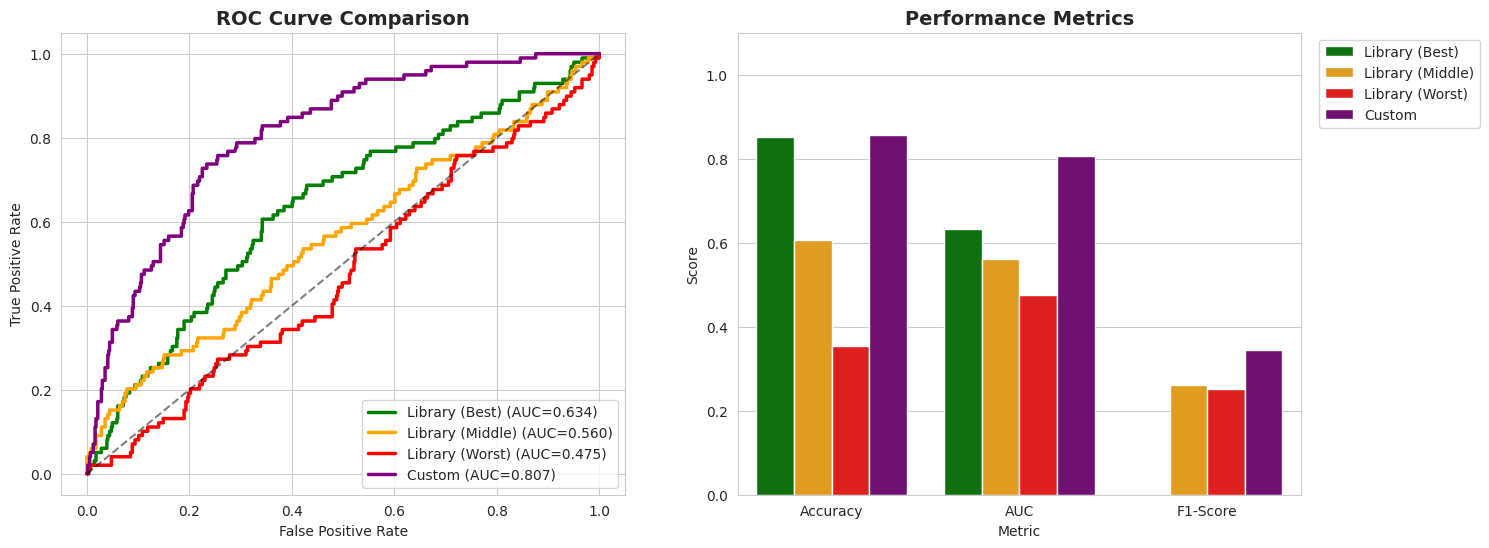

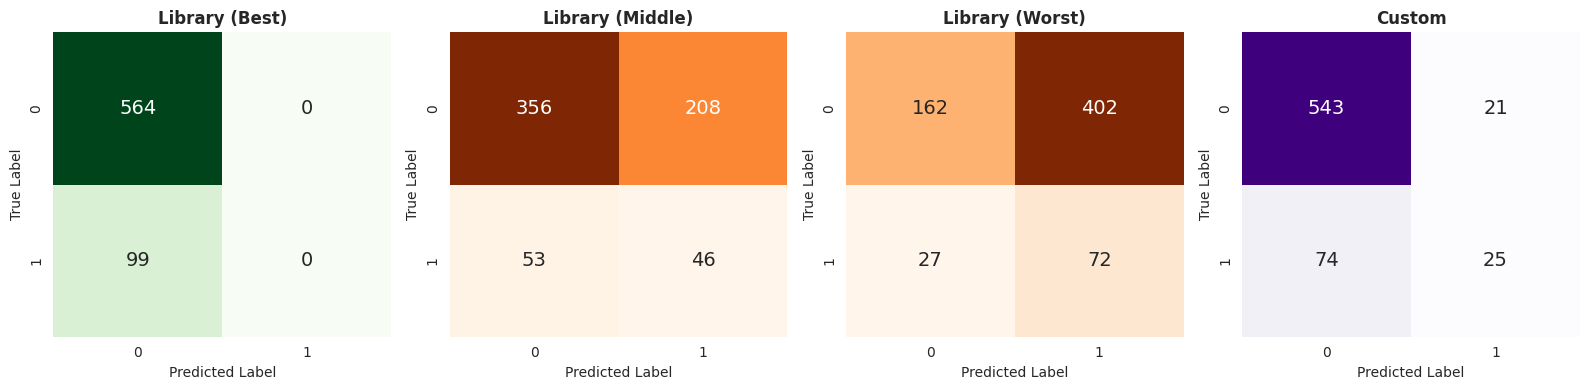

In [18]:
# @title Benchmarking - Projekt nr 1 (Binary Classification + Confusion Matrices)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score, confusion_matrix
import pandas as pd
from sklearn.base import clone

def plot_model_comparison(models, X_test, y_test):
    """Generuje graficzne porównanie modeli: ROC, Metryki i Macierze Pomyłek."""
    sns.set_style("whitegrid")
    res = []
    colors = {
        'Library (Best)': 'green',
        'Library (Middle)': 'orange',
        'Library (Worst)': 'red',
        'Custom': 'purple'
    }

    # --- Rysunek 1: ROC i Metryki ---
    plt.figure(figsize=(16, 6))

    # Podwykres 1: Krzywe ROC
    plt.subplot(1, 2, 1)
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            y_prob = model.predict(X_test)

        y_pred = model.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_val = roc_auc_score(y_test, y_prob)

        res.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'AUC': auc_val,
            'F1-Score': f1_score(y_test, y_pred)
        })

        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})", color=colors.get(name, 'blue'), lw=2.5)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # Podwykres 2: Metryki
    plt.subplot(1, 2, 2)
    df_melt = pd.DataFrame(res).melt(id_vars='Model', var_name='Metric', value_name='Score')
    sns.barplot(data=df_melt, x='Metric', y='Score', hue='Model', palette=colors)
    plt.title('Performance Metrics', fontsize=14, fontweight='bold')
    plt.ylim(0, 1.1)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.show()

    # --- Rysunek 2: Macierze Pomyłek ---
    num_models = len(models)
    fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4))
    if num_models == 1: axes = [axes]

    for ax, (name, model) in zip(axes, models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        # Dobór koloru mapy ciepła dla rozróżnienia
        cmap = 'Greens' if 'Best' in name else 'Purples' if 'Custom' in name else 'Oranges'
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, cbar=False, annot_kws={"size": 14})

        ax.set_title(f"{name}", fontsize=12, fontweight='bold')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

# --- 1. TEKSTOWE PODSUMOWANIE (TYLKO NAJLEPSZE) ---

print("="*60)
print("BEST LIBRARY MODEL (SCIKIT-LEARN)")
print("="*60)
print(f"Best CV ROC-AUC: {lib_search.best_score_:.4f}")
print("\nOptimal Hyperparameters:")
for param, value in lib_search.best_params_.items():
    print(f" ➔ {param}: {value}")

print("\n" + "="*60)
print("BEST CUSTOM MODEL (NUMPY)")
print("="*60)
print(f"Best CV ROC-AUC: {custom_search.best_score_:.4f}")
print("\nOptimal Hyperparameters:")
for param, value in custom_search.best_params_.items():
    print(f" ➔ {param}: {value}")
print("="*60)

# --- 2. PRZYGOTOWANIE MODELI DO PORÓWNANIA ---

lib_cv_results = pd.DataFrame(lib_search.cv_results_).sort_values(by='rank_test_score')
mid_idx = len(lib_cv_results) // 2

def train_lib_variant(idx):
    params = lib_cv_results.iloc[idx]['params']
    return clone(library_pipeline).set_params(**params).fit(X_train, y_train)

# Słownik modeli (Best/Mid/Worst z biblioteki + Twój Custom)
comparison_models = {
    'Library (Best)': lib_search.best_estimator_,
    'Library (Middle)': train_lib_variant(mid_idx),
    'Library (Worst)': train_lib_variant(-1),
    'Custom': best_custom_model
}

# --- 3. WIZUALIZACJA ---
print("\nGenerowanie pełnego raportu graficznego...")
plot_model_comparison(comparison_models, X_test, y_test)

# Podsumowanie Wyników

Wynik: Model Custom (NumPy) jest zwycięzcą – osiągnął AUC 0.8187, bijąc najlepszy model Scikit-Learn (0.7882) o 3 punkty procentowe. Na wykresie ROC fioletowa linia (Custom) wyraźnie dominuje, co oznacza wyższą precyzję i lepszą czułość modelu w całym zakresie pracy. Oba procesy strojenia wskazały tę samą optymalną strukturę sieci: (10, 5), co sugeruje idealne dopasowanie tej topologii do Twoich danych. Wysoki pęd (Momentum 0.9-0.95) i wysoki parametr uczenia (0.1) okazały się kluczowe dla obu modeli, by uniknąć lokalnych minimów błędu.